In [177]:
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
from scipy.stats import gennorm
from scipy.stats import gamma
from IPython import display
%matplotlib inline

def generate_initial_coordinates(side_length=2000, n_pokemon=9):
    pokemons = {}
    for i in range(n_pokemon):
        pokemons[i] = np.array([random.uniform(-side_length/2, side_length/2), random.uniform(-side_length/2, side_length/2)])
    return pokemons

def distance(coord1, coord2):
    return np.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

# this is not visible to players
def pokemon_distances(player_coord, pokemons):
    return {i: distance(player_coord, coord) for i, coord in pokemons.items()}

def particle_distances(player_coord, particles):
    return np.sqrt(np.sum((player_coord - particles)**2, axis=1))

def rank(input):
    output = [0] * len(input)
    for i, x in enumerate(sorted(range(len(input)), key=lambda y: input[y])):
        output[x] = i
    return output

# player will be able to see this
# slight bug - we will not be able to see rankings of pokemons that are out of radar radius (but we can fix this later)
def pokemon_rankings(player_coord, pokemons):
    dists = pokemon_distances(player_coord, pokemons)
    rankings = {}
    for i, x in enumerate(sorted(range(len(dists)), key=lambda y: dists[y])):
        rankings[x] = i
    return rankings

def plot_pokemons(player_coord, pokemons, xylim=(-1100, 1100)):
    plt.figure(figsize=(15,15))
    # non-target pokemons
    plt.scatter([x - player_coord[0] for x, y in [coord for coord in pokemons.values()]][1:], 
                [y - player_coord[1] for x, y in [coord for coord in pokemons.values()]][1:])
    # target pokemon
    plt.scatter([x - player_coord[0] for x, y in [coord for coord in pokemons.values()]][0], 
                [y - player_coord[1] for x, y in [coord for coord in pokemons.values()]][0],
               marker="*", color='red', s=15)
    plt.axes().set_aspect(1)
    plt.axes().set_xlim(xylim)
    plt.axes().set_ylim(xylim)
    # player
    plt.scatter(0, 0 , color='purple', s=15)
    # detection radii
    dists = {10:'green', 25:'blue', 100:'yellow', 1000:'red'}
    for r in dists:
        plt.axes().add_patch(plt.Circle((0,0), r, fill=False, color=dists[r]))
    plt.show()
    
def footprint(distance):
    if distance < 10:
        return 0
    elif distance < 25:
        return 1
    elif distance < 100:
        return 2
    elif distance < 1000:
        return 3
    else:
        return 'out'

def distance_levels(player_coord, pokemons):
    dists = pokemon_distances(player_coord, pokemons)
    return {i: footprint(v) for i,v in dists.items()}

def random_particle_generation(side_length=2000, n=1000):
    particles = np.ndarray((n, 2))
    for i in range(n):
        particles[i] = random.uniform(-side_length/2, side_length/2), random.uniform(-side_length/2, side_length/2)
    return particles

def plot_particles(player_coord, particles, xylim=(-1100, 1100), with_true=False, true_coord=(0, 0)):
    plt.figure(figsize=(15,15))
    plt.scatter([p[0] for p in particles], 
                [p[1] for p in particles], s=1)
    plt.axes().set_aspect(1)
    plt.axes().set_xlim(xylim)
    plt.axes().set_ylim(xylim)
    # player
    plt.scatter(*player_coord, color='purple', s=50)
    # detection radii
    dists = {10:'green', 25:'blue', 100:'yellow', 1000:'red'}
    for r in dists:
        plt.axes().add_patch(plt.Circle(player_coord, r, fill=False, color=dists[r]))
    if with_true:
        plt.scatter(*true_coord , color='red', s=50, marker='*')
    plt.show()
    
distributions = {
    0: lambda x: gennorm.pdf(x / 10*0.9, 10),
    1: lambda x: gennorm.pdf((x - 17.5) / 7.5, 10),
    2: lambda x: gennorm.pdf((x - 62.5) / 37.5*0.9, 10),
    3: lambda x: gennorm.pdf((x - 550) / 450*0.9, 20),
    'in': lambda x: gamma.pdf((-x + 1100) / (450/6), 1.5),
    'out': lambda x: gamma.pdf((x - 900) / (450/2), 2),
    'invis': np.vectorize(lambda x: 1)
}

# def resample_population(particles, particle_weights):
#     return [particles[np.random.choice(range(len(particles)), p=particle_weights / sum(particle_weights))] 
#             for i in range(len(particles))]

def resample_population(particles, particle_weights):
    return particles[np.random.choice(range(len(particles)), size=len(particles), p=particle_weights / sum(particle_weights))]

def resample_all_population(all_particles, all_particle_weights, portion=0.5):
    return {i: particles[np.append(np.random.choice(range(len(particles)), size=int(len(particles)*portion), 
                                                    p=all_particle_weights[i] / sum(all_particle_weights[i])), 
                                   np.random.choice(range(len(particles)), size=len(particles) - int(len(particles)*portion), 
                                                    replace=True))]
            for i, particles in all_particles.items()}

# def distance_level_weights(particle_distances, distance_level, distributions=distributions):
#     particle_weights = list(map(distributions[distance_level], particle_distances))
#     return particle_weights

def distance_level_weights(particle_distances, distance_level, distributions=distributions):
    return distributions[distance_level](particle_distances)

def all_distance_level_weights(all_particle_distances, all_distance_levels, distributions=distributions):
    return {i:distributions[all_distance_levels[i]](distances) for i, distances in all_particle_distances.items()}

def all_particle_distances(player_coord, all_particles):
    return {i: particle_distances(player_coord, v) for i,v in all_particles.items()}

def all_ranking_weights(all_particle_distances, rankings):
    # get sorted distances
    all_sorted_distances = {i: np.sort(distances) for i, distances in all_particle_distances.items()}
    # loop through all pokemons
    likelihoods = {}
    for i, distances in all_particle_distances.items():
        # select pokemons in neighbouring rankings
        selected_ranking = rankings[i]
        if selected_ranking == 0:
            prev_id = None
            next_id = next((k for k,v in rankings.items() if v == rankings[i] + 1))
        elif selected_ranking == len(rankings) - 1:
            next_id = None
            prev_id = next((k for k,v in rankings.items() if v == rankings[i] - 1))
        else:
            prev_id = next((k for k,v in rankings.items() if v == rankings[i] - 1))
            next_id = next((k for k,v in rankings.items() if v == rankings[i] + 1))
        # calculate weights for particle population
        if prev_id == None:
            prev_probs = 1
        else:
#             prev_probs = np.array([sum(a > all_particle_distances[prev_id]) for a in all_particle_distances[i]])
            prev_probs = np.searchsorted(all_sorted_distances[prev_id], all_particle_distances[i])
        if next_id == None:
            next_probs = 1
        else: 
#             next_probs = np.array([sum(a < all_particle_distances[next_id]) for a in all_particle_distances[i]])
            next_probs = len(distances) - np.searchsorted(all_sorted_distances[next_id], all_particle_distances[i])
        likelihoods[i] = prev_probs * next_probs
    return likelihoods

def average_location(particles):
    return (np.mean(particles[:, 0]), np.mean(particles[:, 1]))

def make_rand_vector(dims):
    vec = np.array([random.gauss(0, 1) for i in range(dims)])
    mag = np.linalg.norm(vec)
    return vec / mag

def plot_all_particles(player_coord, all_particles, xylim=(-1100, 1100), true_coords=None):
    fig = plt.figure(figsize=(15,15))
    plt.axes().set_aspect(1)
    plt.axes().set_xlim(xylim)
    plt.axes().set_ylim(xylim)
    dists = {10:'green', 25:'blue', 100:'yellow', 1000:'red'}
    for r in dists:
        plt.axes().add_patch(plt.Circle(player_coord, r, fill=False, color=dists[r]))
    plt.scatter(*player_coord, color='purple', s=50)
    cmap = plt.get_cmap('Accent')
    for i, particles in all_particles.items():
        plt.scatter([p[0] for p in particles], 
                    [p[1] for p in particles], s=1, color=cmap(i / (len(all_particles) - 1)))
    if true_coords != None:
        for i, pokemon in true_coords.items():
            plt.scatter(*pokemon, s=50, color=cmap(i / (len(all_particles) - 1)))
#     plt.show()
    return fig
        

**simulator**

In [178]:
def pokemon_simulation(particle_count=10000, log_frequency=5, step_length=5, no_change_update_steps = 20):
    # generate pokemons
    pokemons = generate_initial_coordinates(side_length=2000, n_pokemon=9)
    # assign an id to the tracked pokemon
    tracked_id = 0
    # initialise player coordinate
    player_coord = np.array([0., 0.])
    
    # initialise learner
    learner = ParticleFilterLearner(particle_count, pokemons, resample_step=5)
    learner.set_tracked_id(tracked_id)
    
    # set step counter
    no_change_counter = 0
    total_moves = 0
    # initial step
    levels = distance_levels(player_coord, pokemons)
    rankings = pokemon_rankings(player_coord, pokemons)
    last_levels = levels
    last_rankings = rankings
    learner.update_levels(player_coord, levels)
    learner.update_rankings(player_coord, rankings)
    player_delta = make_rand_vector(2) * step_length
    # start iteration
    # check if target reached
    for player_coord in spiral_search_location_generator():
        # get distance levels
        levels = distance_levels(player_coord, pokemons)
        # get distance rankings
        rankings = pokemon_rankings(player_coord, pokemons)
        # check if any changes from last values
#         if levels != last_levels:
        learner.update_levels(player_coord, levels)
#         if rankings != last_rankings:
        learner.update_rankings(player_coord, rankings)
        total_moves += 1
        no_change_counter += 1
        if no_change_counter >= no_change_update_steps:
            # change direction
            learner.update_levels(player_coord, levels)
            learner.update_rankings(player_coord, rankings)
            no_change_counter = 0
        if total_moves % log_frequency == 0:
            # log output...
#             print("total moves = " + str(total_moves))
            # debug
#             td = distance(player_coord, pokemons[tracked_id])
#             print("true distance = " + str(td))
#             print("levels :" + str(levels))
#             print("rankings:" + str(rankings))
            learner.plot_all_population(player_coord, true_coords=pokemons)
        # update last
        last_levels = levels
        last_rankings = rankings
    
    # game success
    # print outcome...
    return True

In [179]:
def spiral_search_location_generator(step_length=50):
    counter = 0
    location = np.array([0., 0.])
    move = np.array([1., 0.])
    m = np.matrix('0., -1.; 1., 0.')
    while np.all(np.abs(location) < 1000):
        counter += 1
        location = location + move * np.ceil(counter / 2) * step_length
        move = move * m
        yield np.squeeze(np.asarray(location))

In [182]:
class ParticleFilterLearner:
    tracked_id = 0
    
    def __init__(self, particle_count, pokemons, resample_step=5):
        # generate particle populations for each pokemon
        self.all_particles = {i: random_particle_generation(n=particle_count) for i in range(len(pokemons))}
        self.resample_step = resample_step
        self.frame = 0
        print("particles initialised!")
        
#     def cheat_true_coord(self, coord):
#         self.true_coord = coord
        
    def get_estimated_target_direction(self, player_coord):
        # get average target location
        target = average_location(self.all_particles[self.tracked_id])
        # get direction vector
        vector = target - player_coord
        vector = vector / np.linalg.norm(vector)
        return vector
    
    def update_levels(self, player_coord, levels):
        # calculate particle distances
        distances = all_particle_distances(player_coord, self.all_particles)
        # get level weights
        level_weights = all_distance_level_weights(distances, levels)
        # resample according to level weights
        self.all_particles = resample_all_population(self.all_particles, level_weights, portion=1)
        
    def update_rankings(self, player_coord, rankings):
        # calculate particle distances
        distances = all_particle_distances(player_coord, self.all_particles)
        # get ranking weights
        ranking_weights = all_ranking_weights(distances, rankings)
        # resample according to ranking weights
        self.all_particles = resample_all_population(self.all_particles, ranking_weights, portion=1)
        
    def plot_population(self, player_coord, true_coord, tracked_id=None):
        if tracked_id == None:
            tracked_id = self.tracked_id
        plot_particles(player_coord, self.all_particles[tracked_id], with_true=True, true_coord=true_coord)
        
    def plot_all_population(self, player_coord, true_coords=None):
        fig = plot_all_particles(player_coord, self.all_particles, true_coords=true_coords)
#         fig.savefig('frame' + str(self.frame) + '.png')
        self.frame += 1
        display.clear_output(wait=True)
        display.display(fig)
    
    def set_tracked_id(self, id):
        self.tracked_id = id

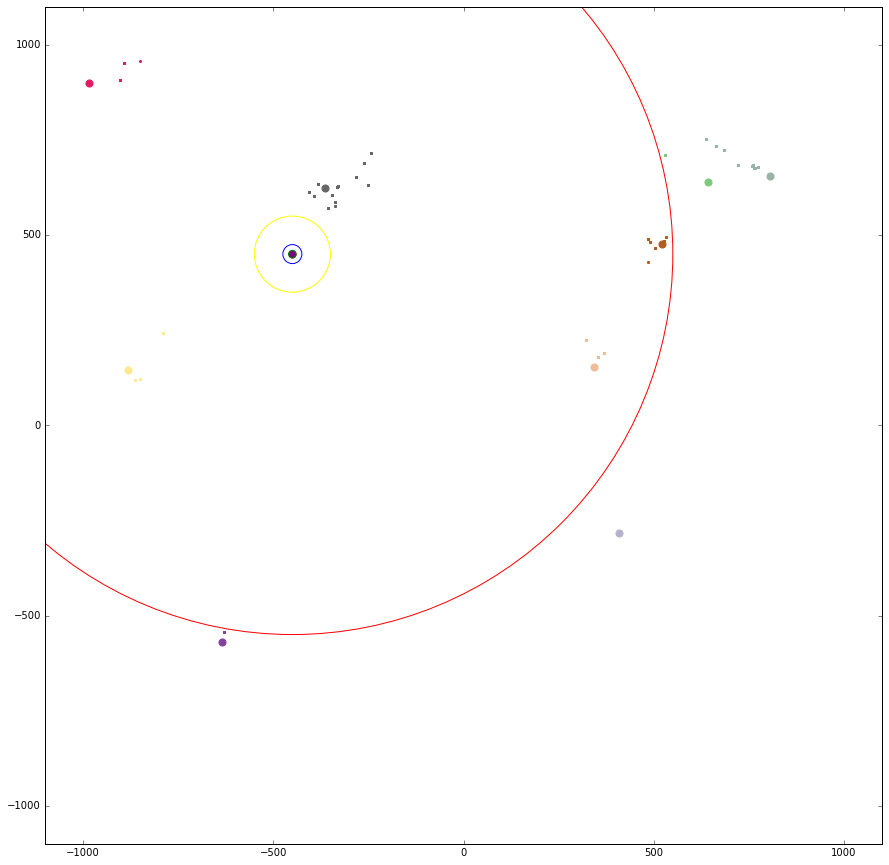

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000023BC496DE18> (for post_execute):


ValueError: object too deep for desired array

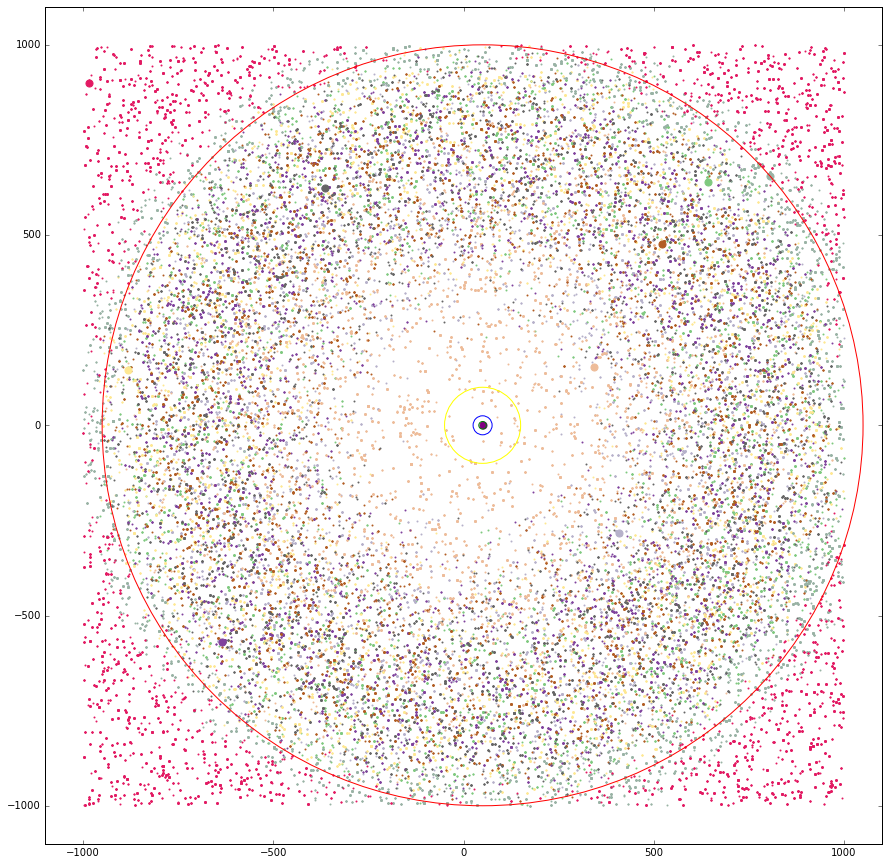

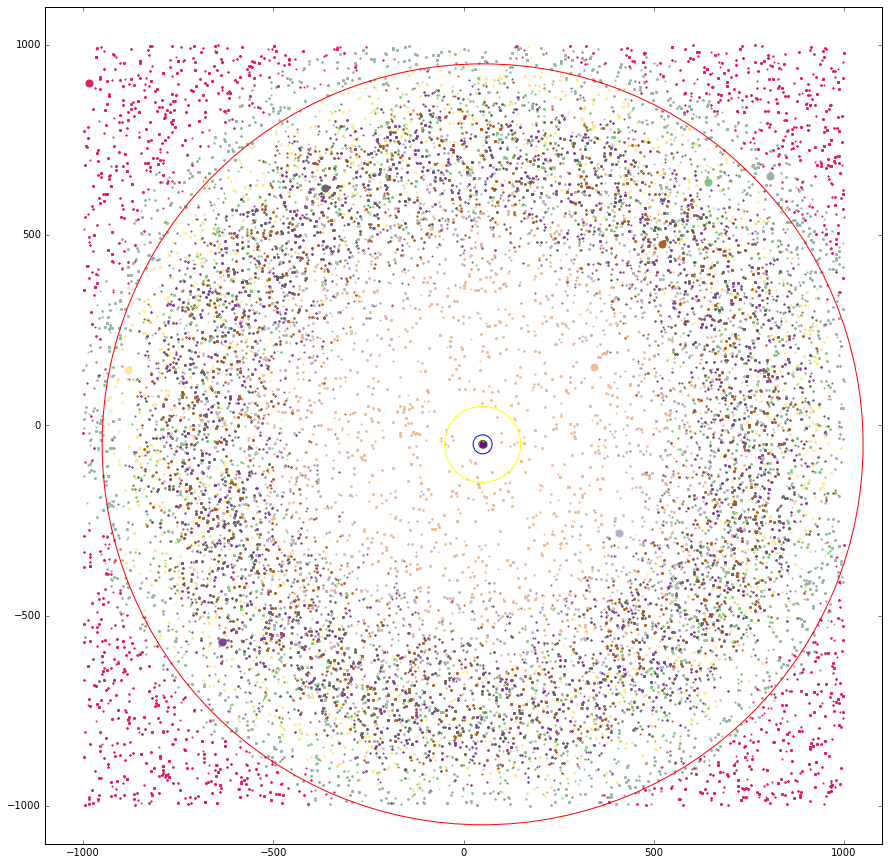

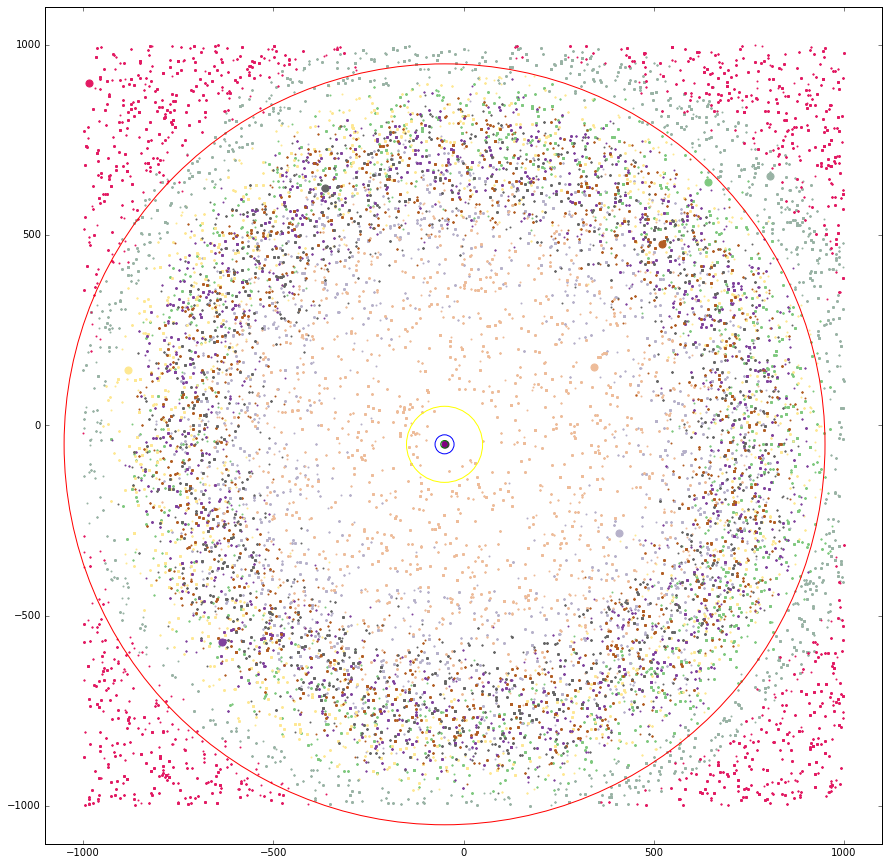

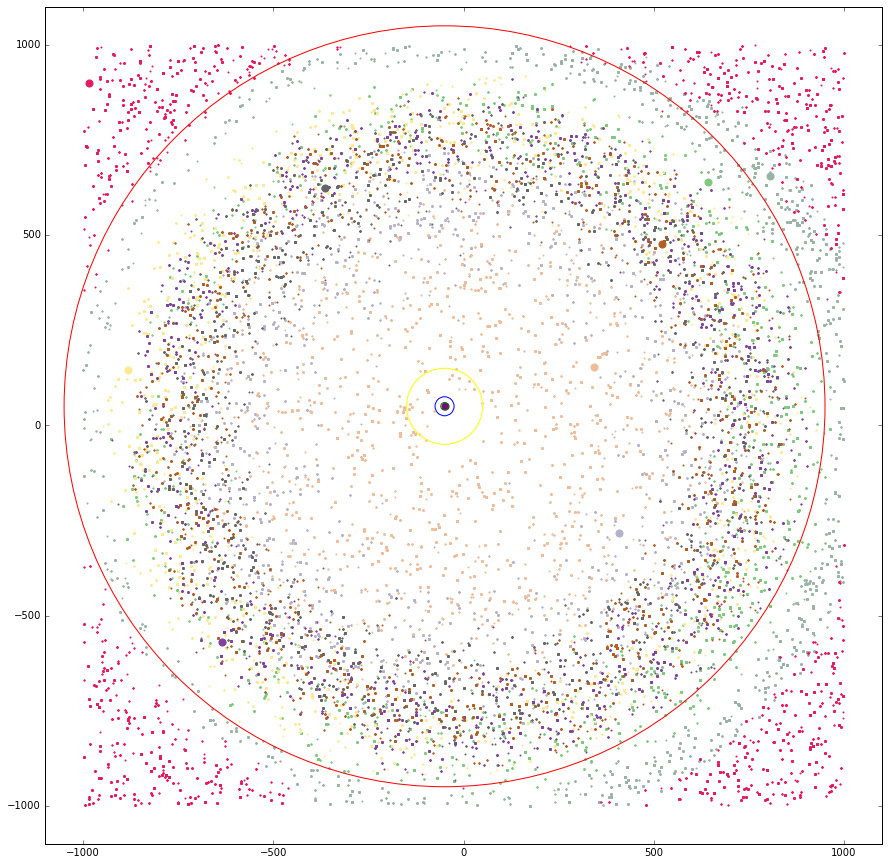

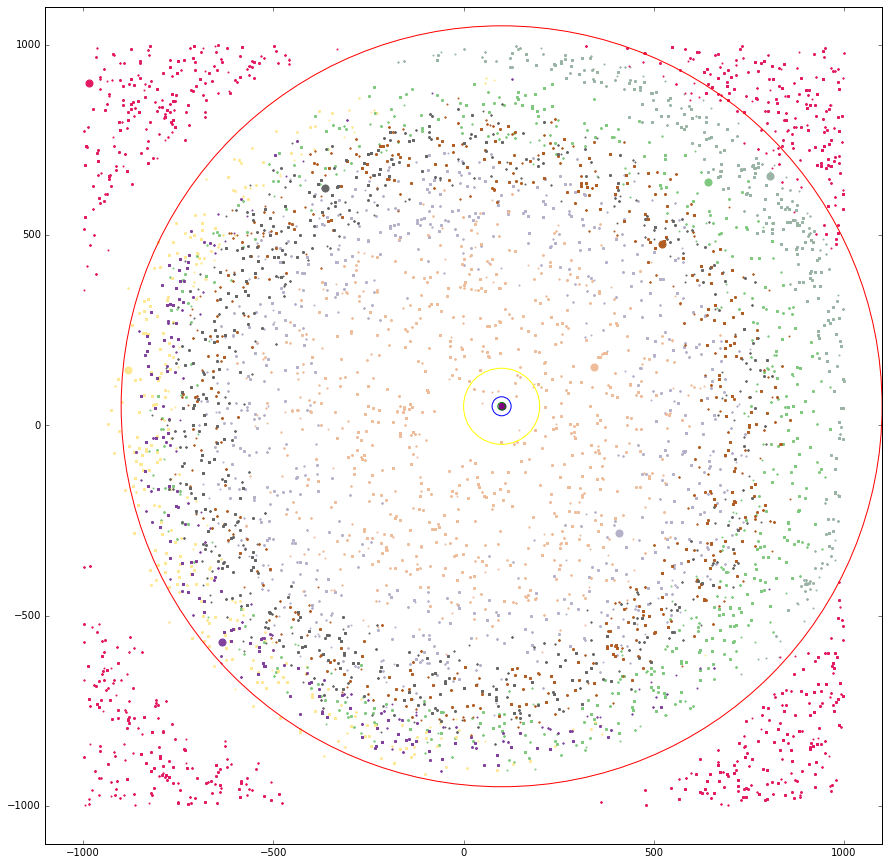

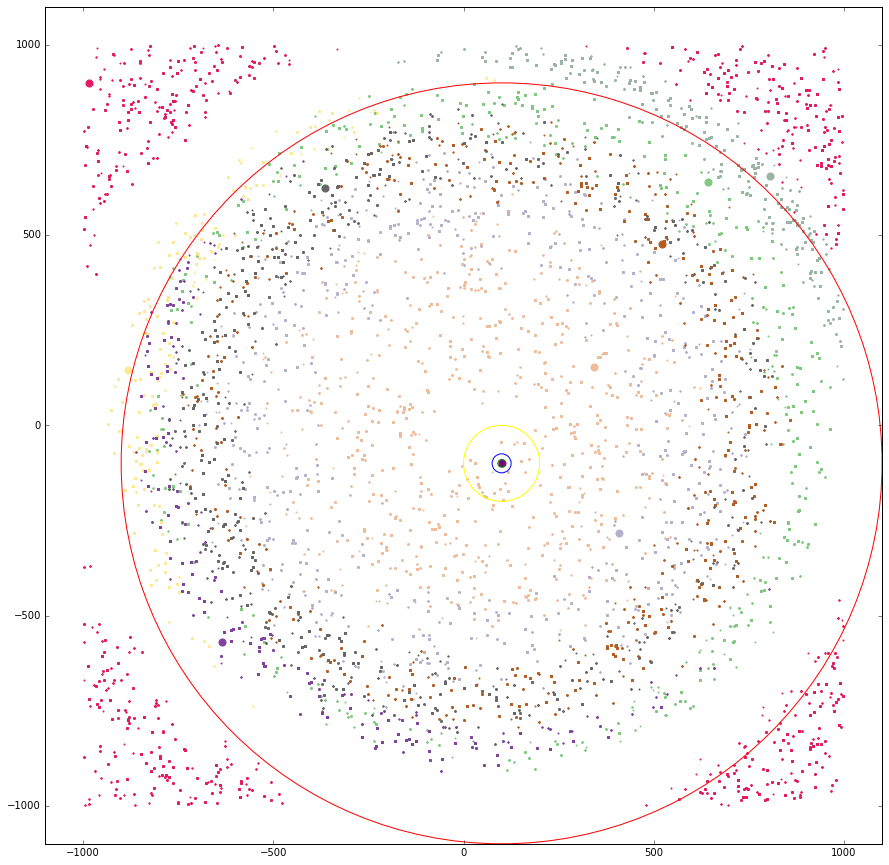

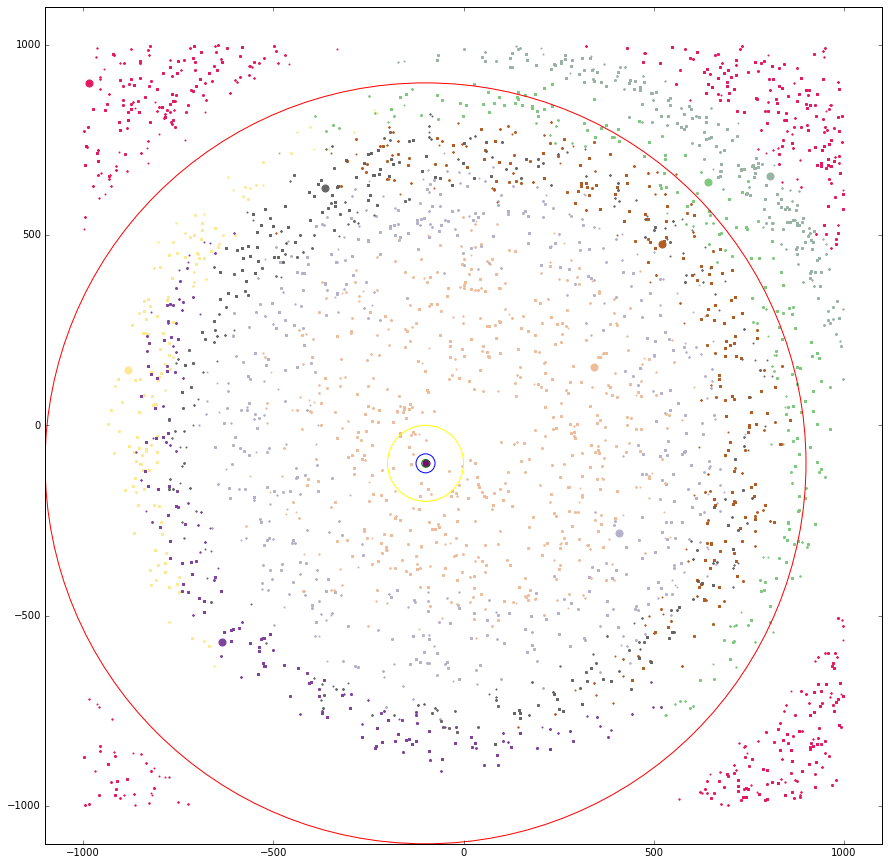

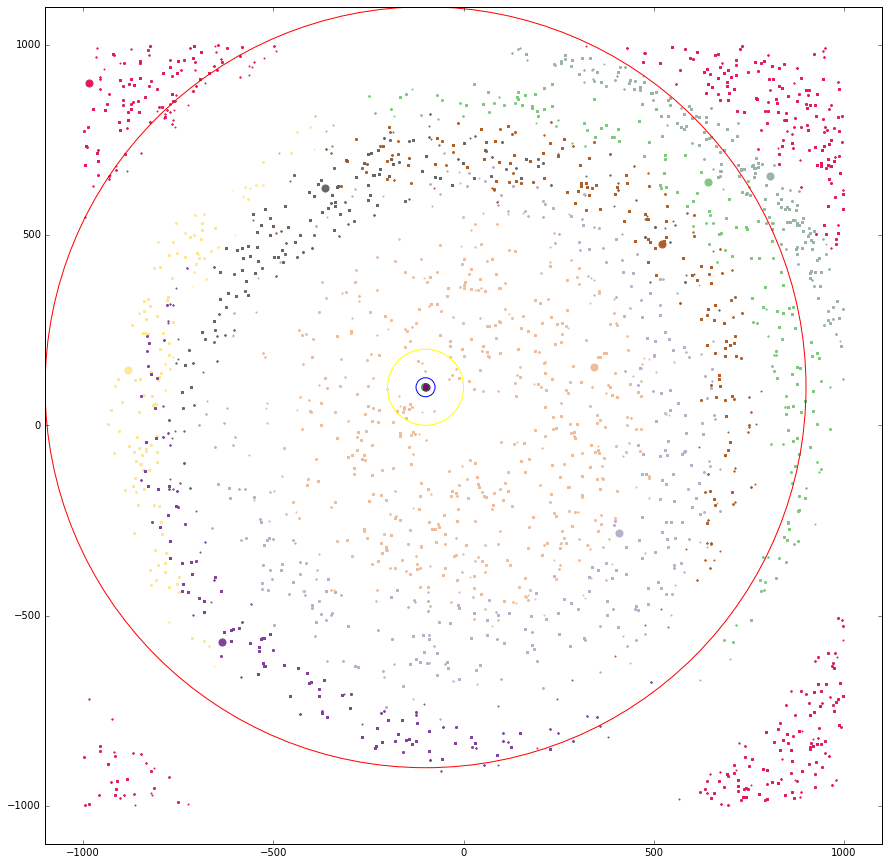

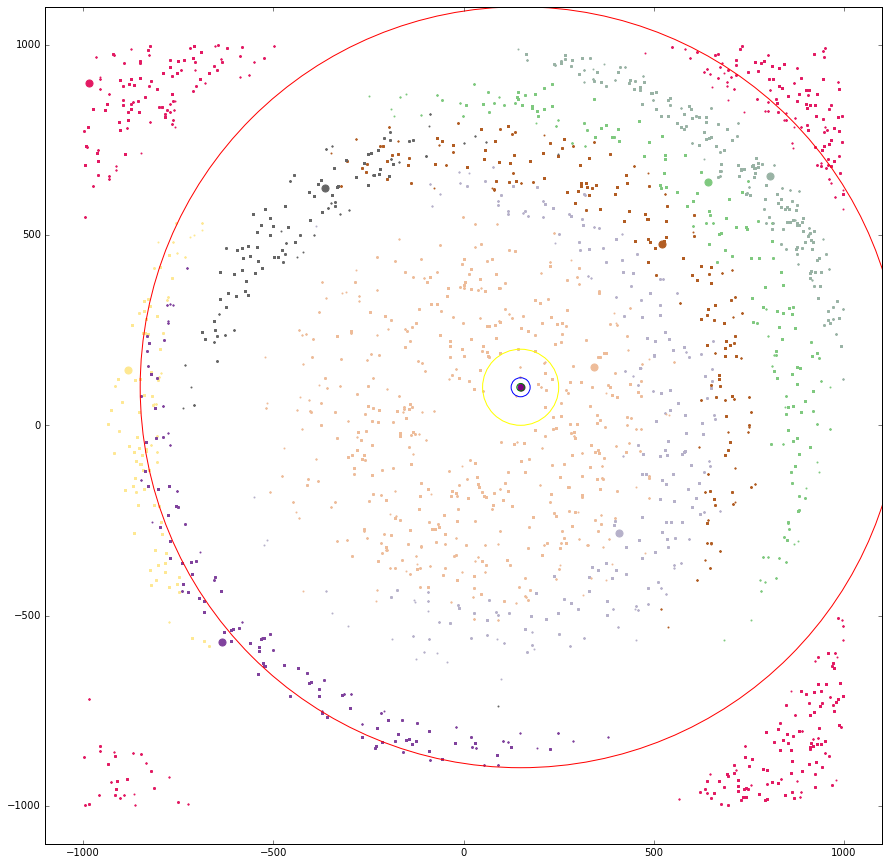

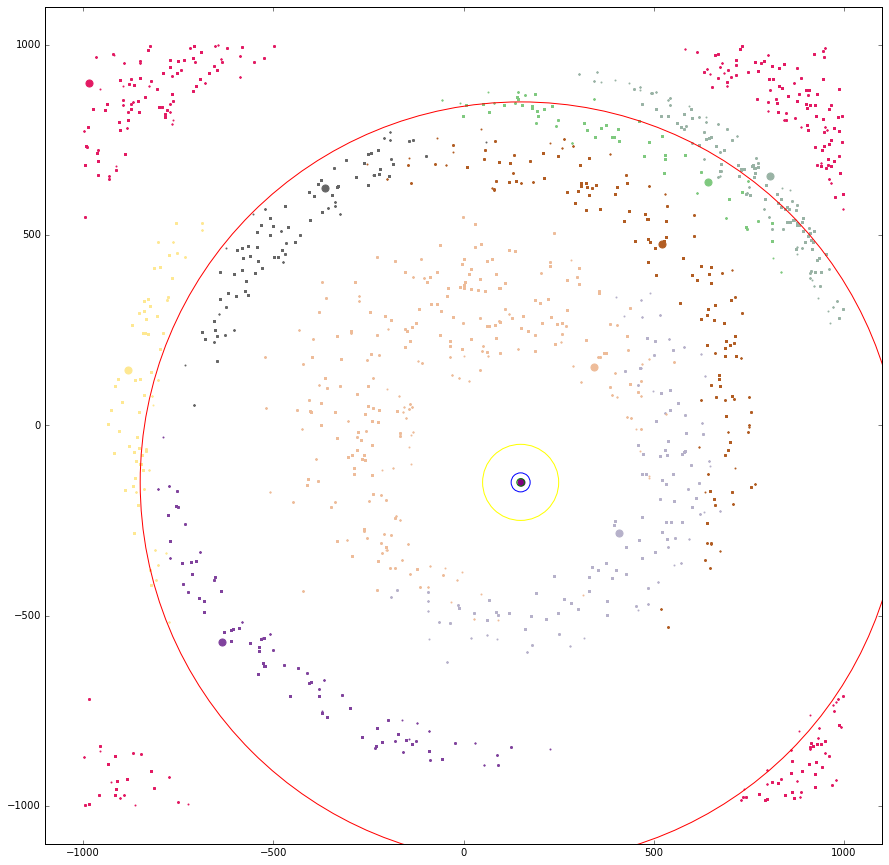

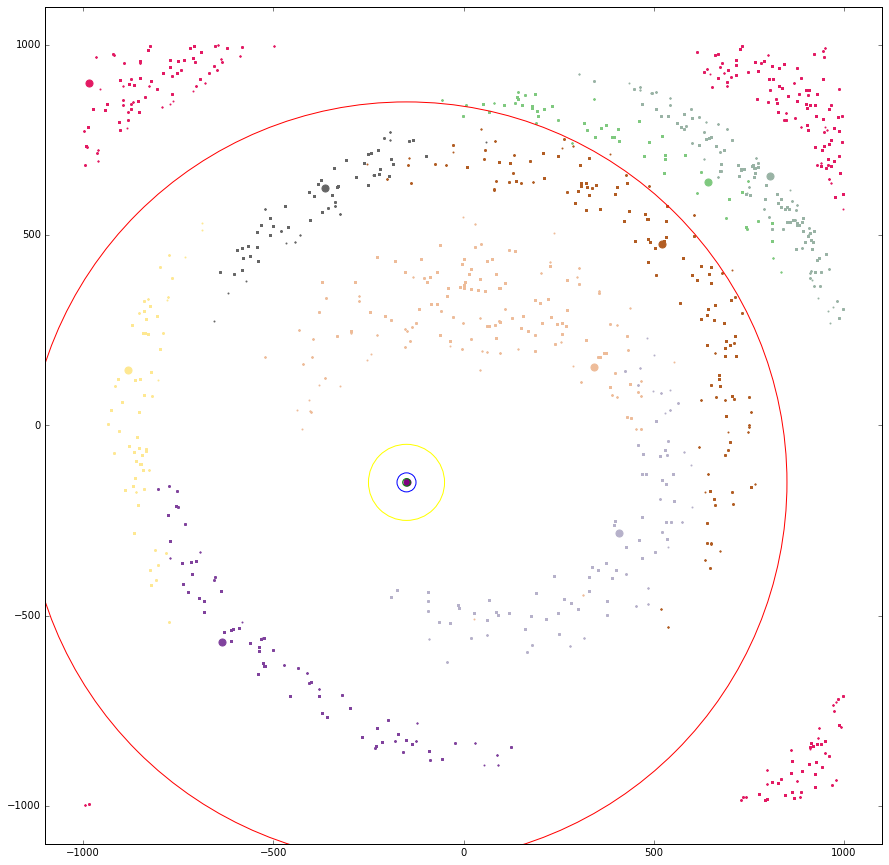

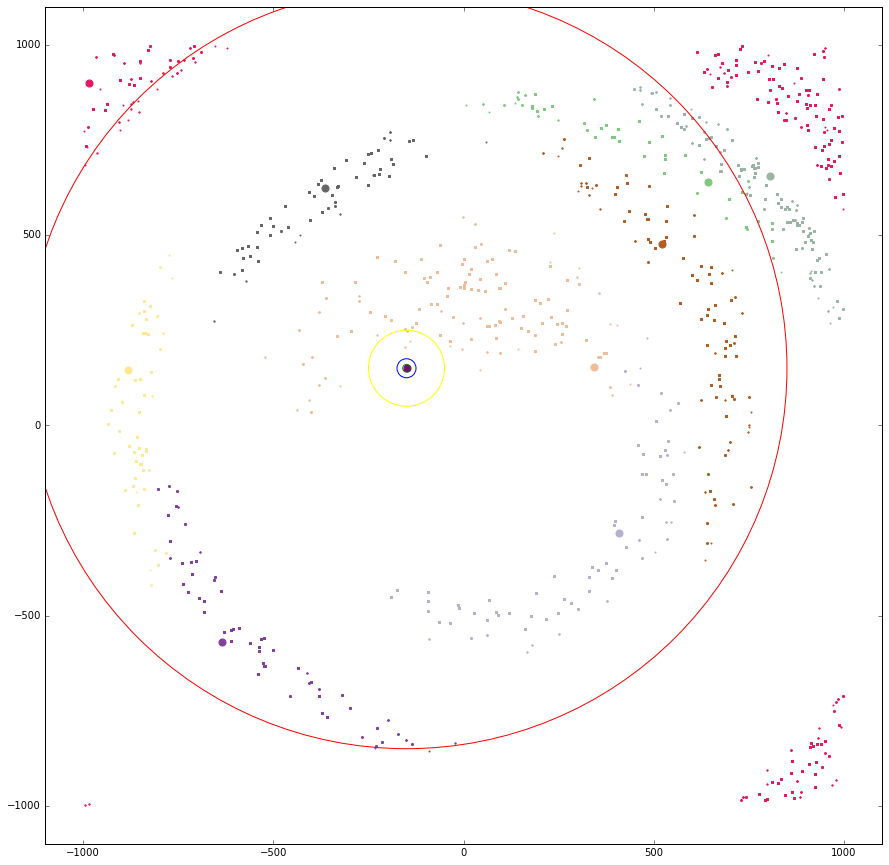

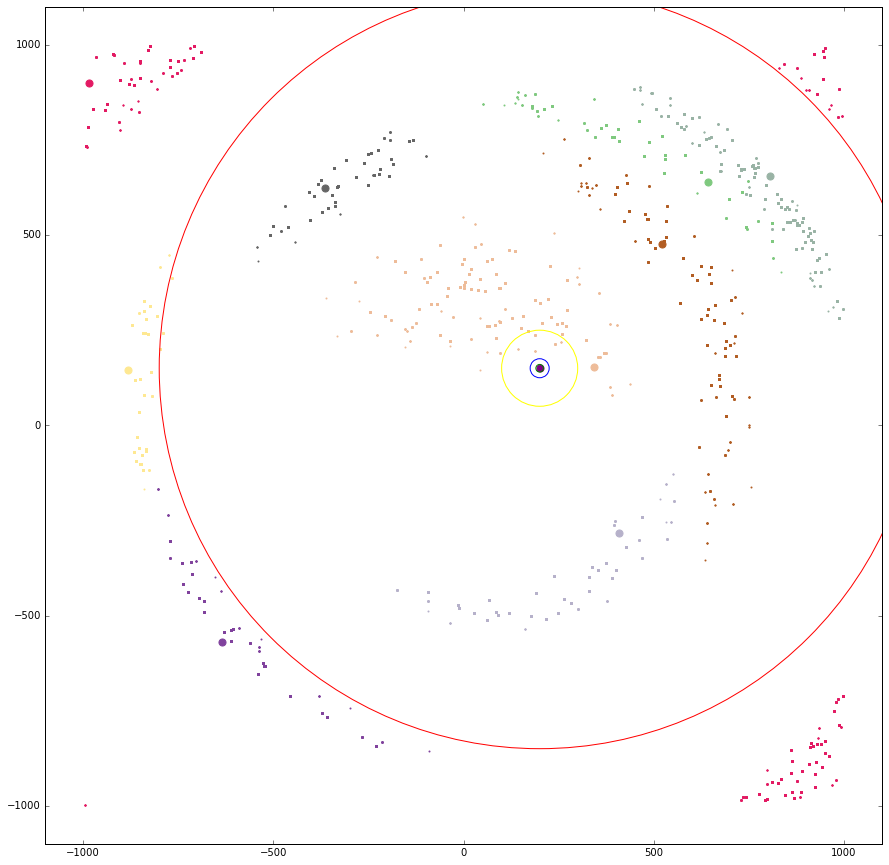

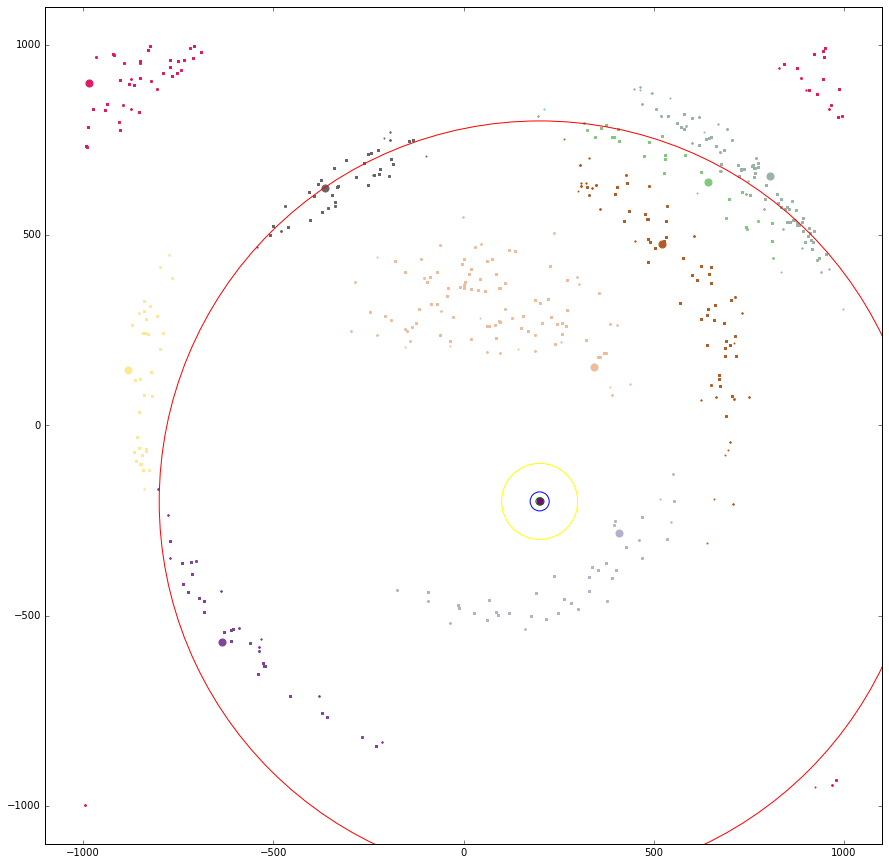

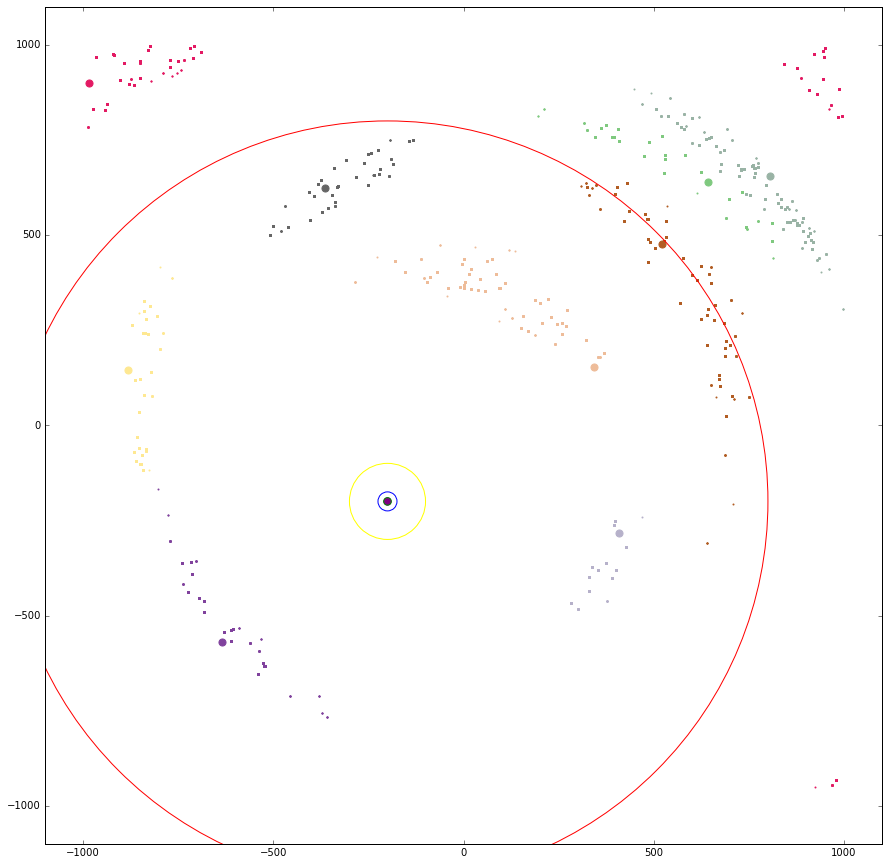

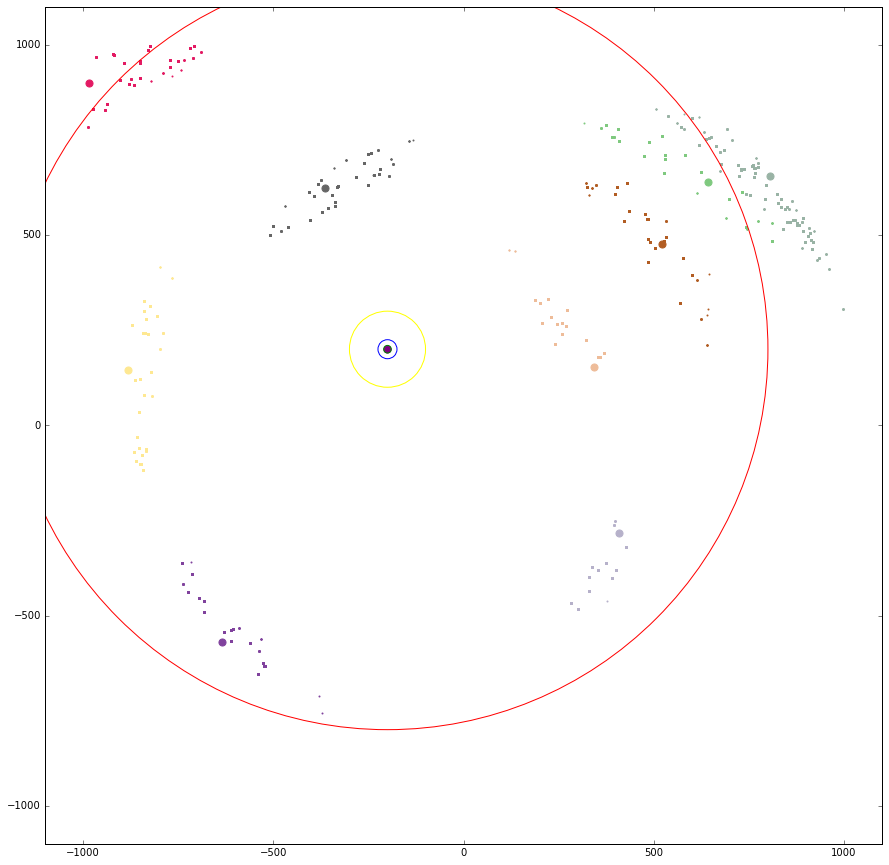

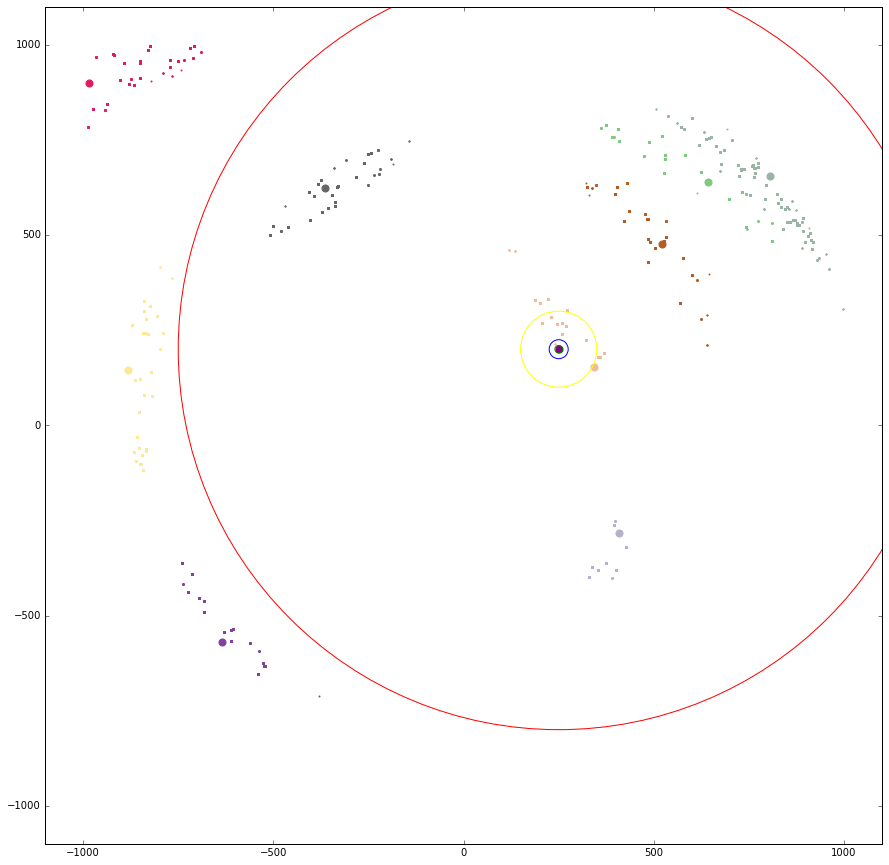

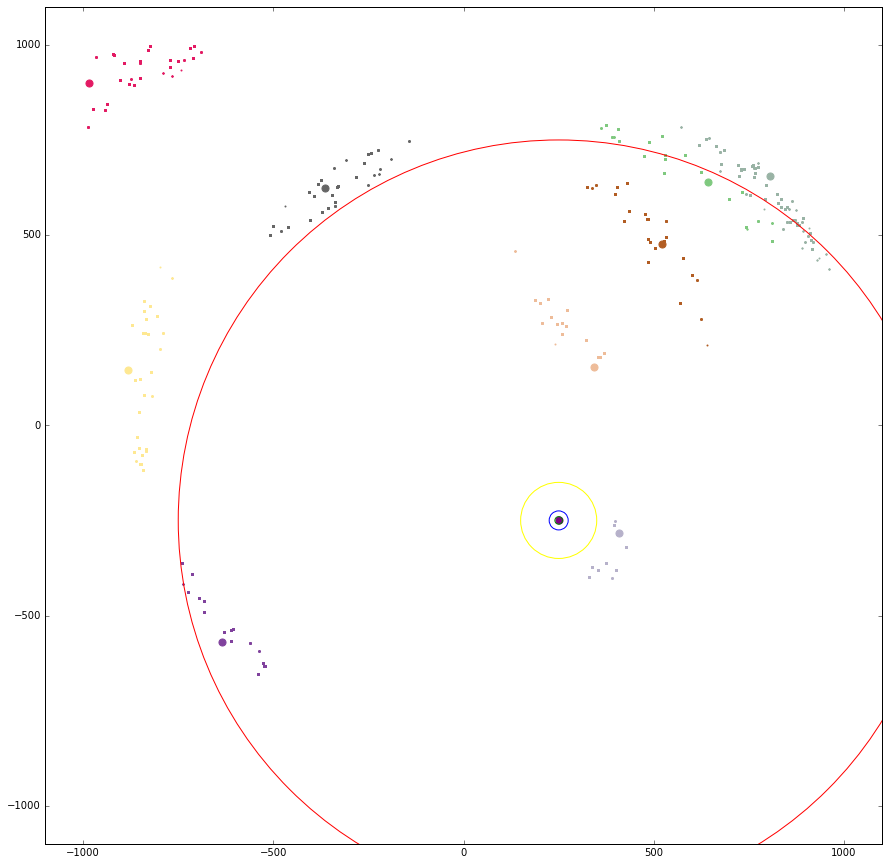

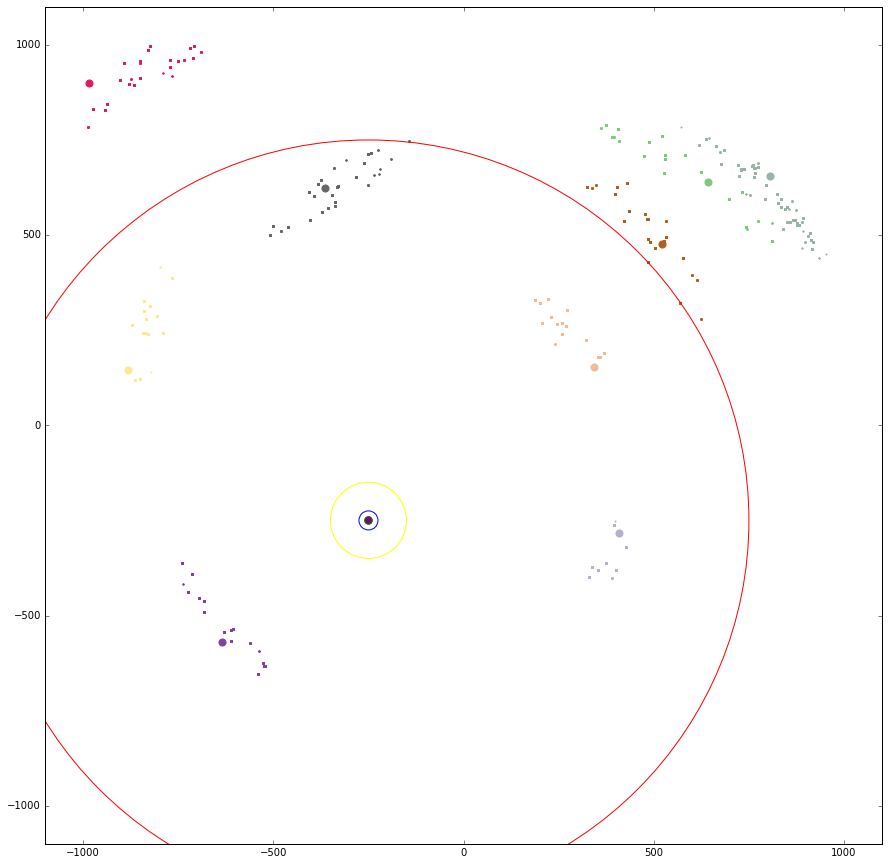

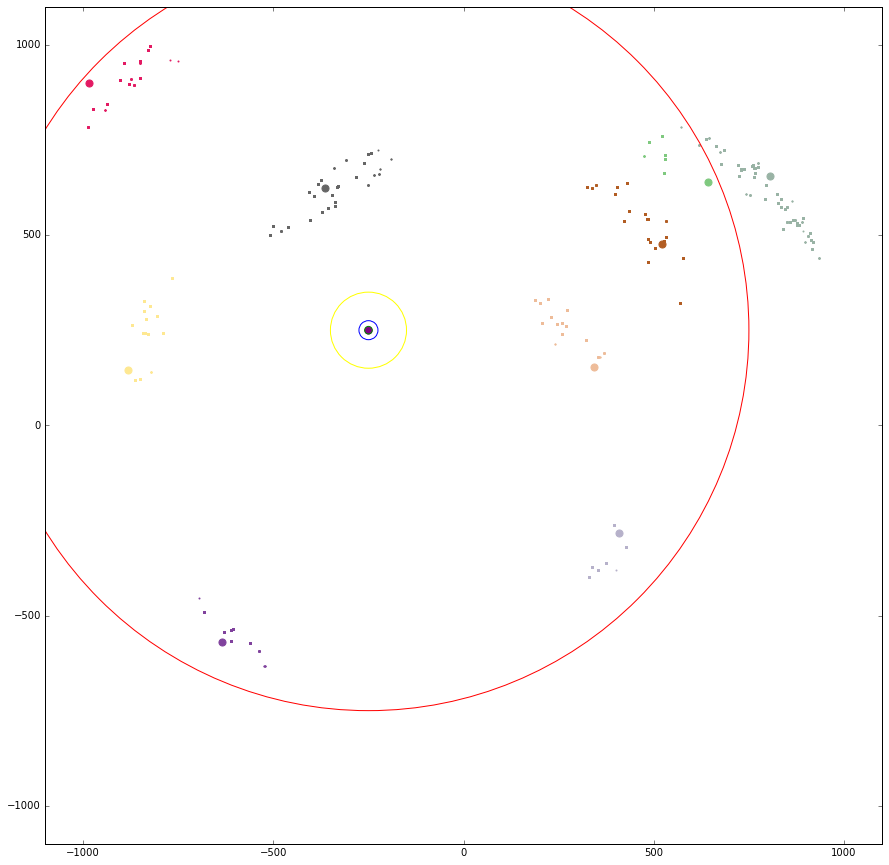

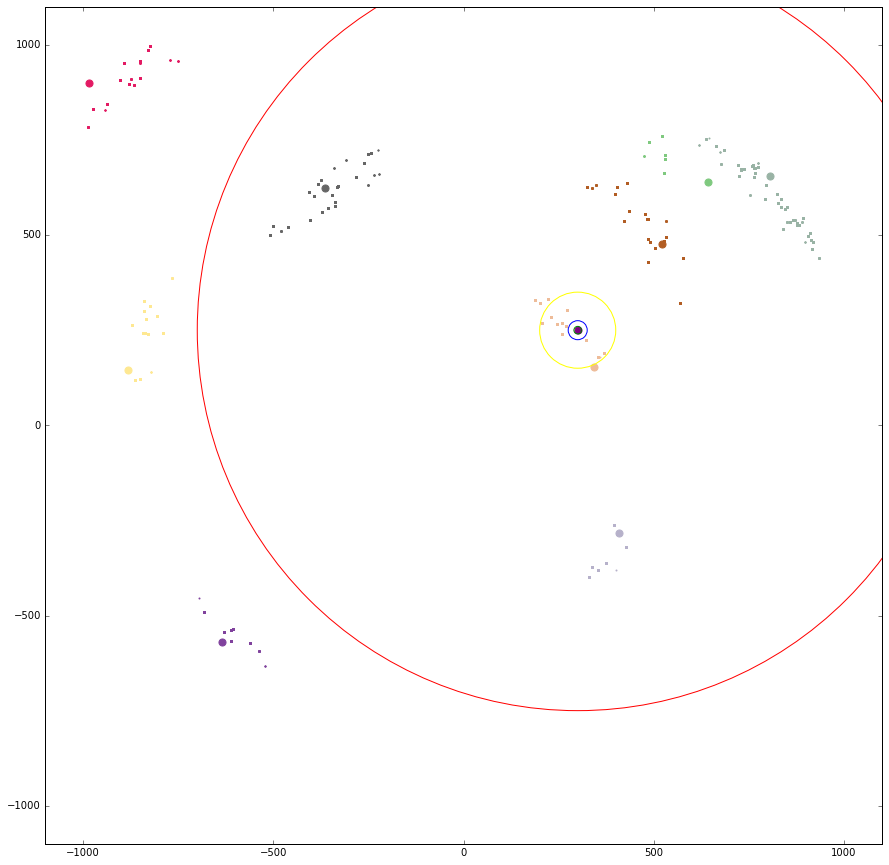

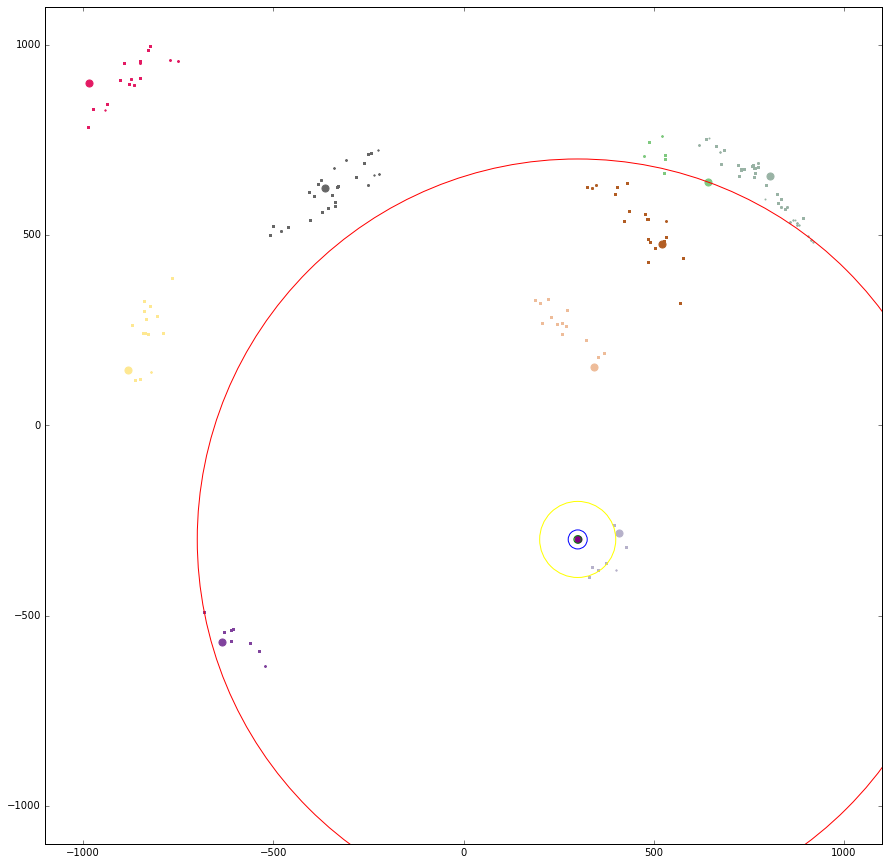

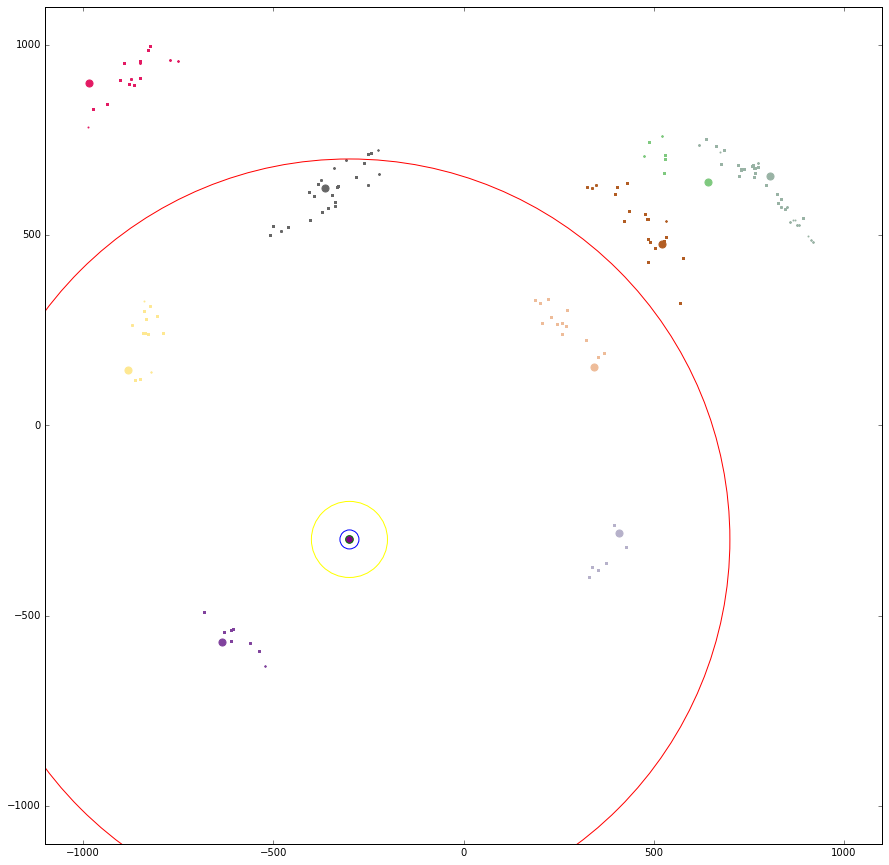

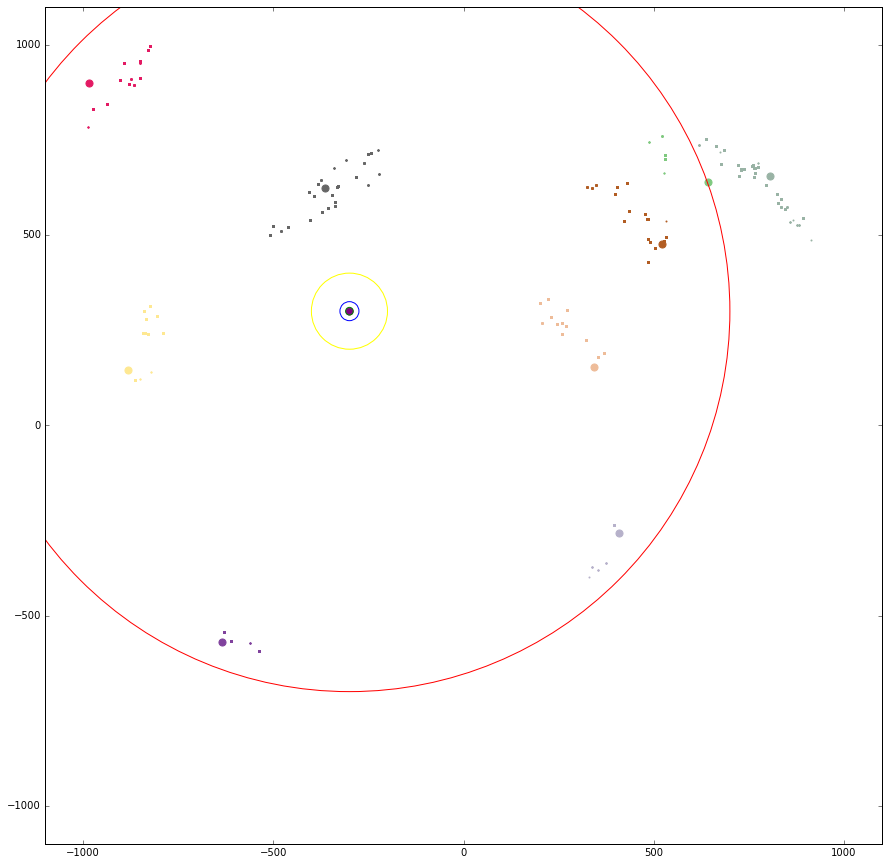

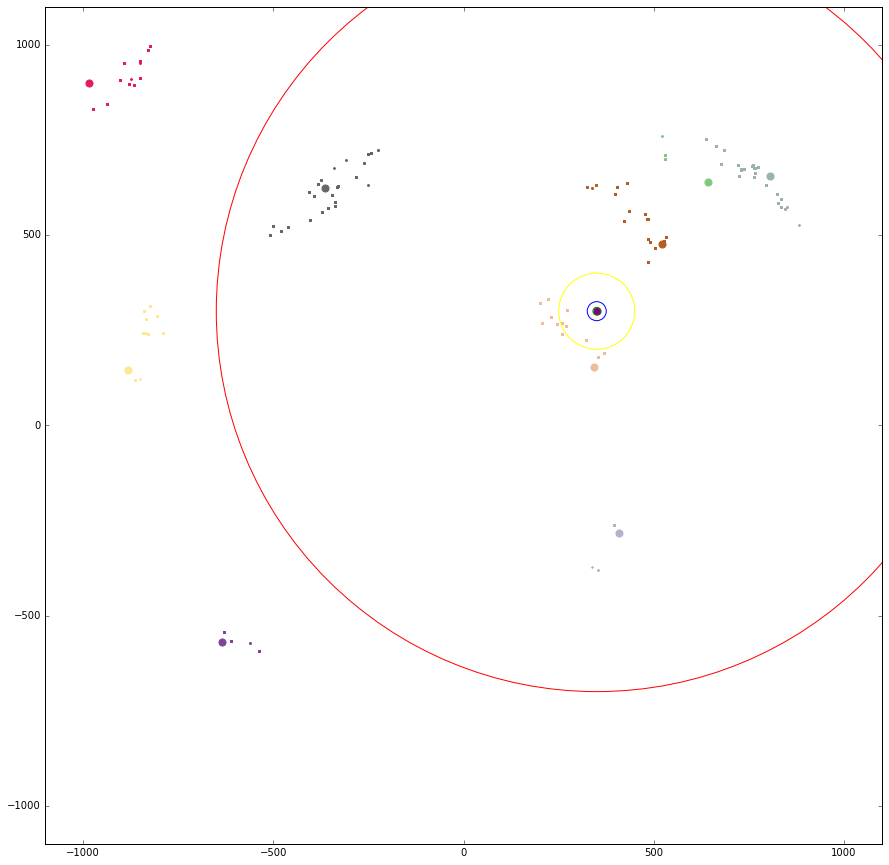

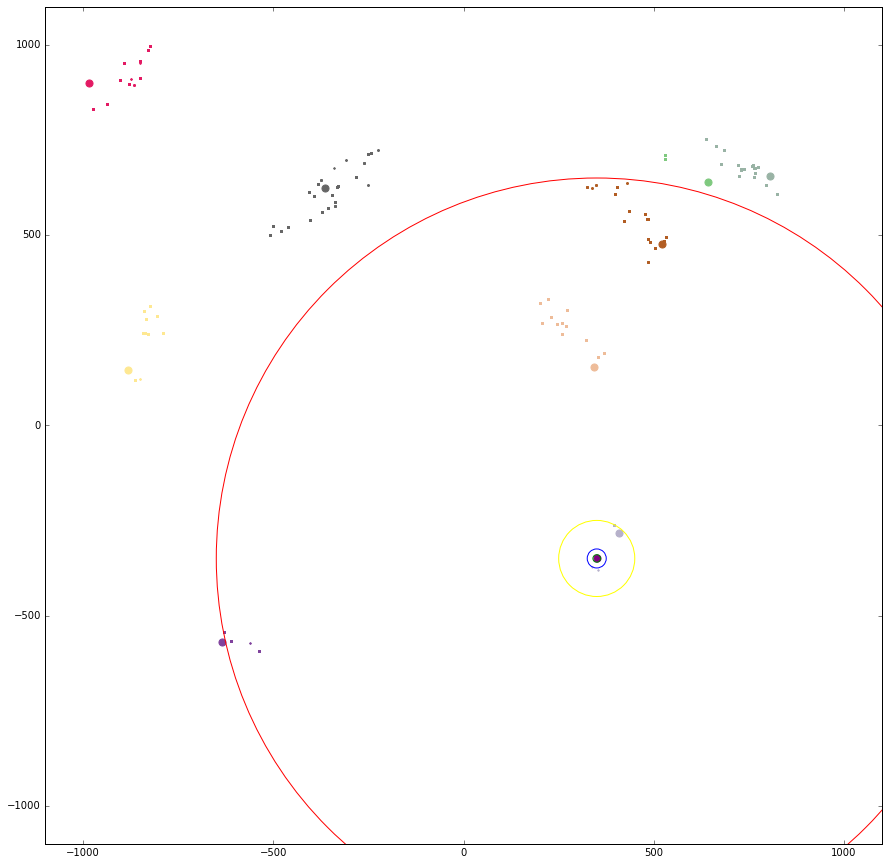

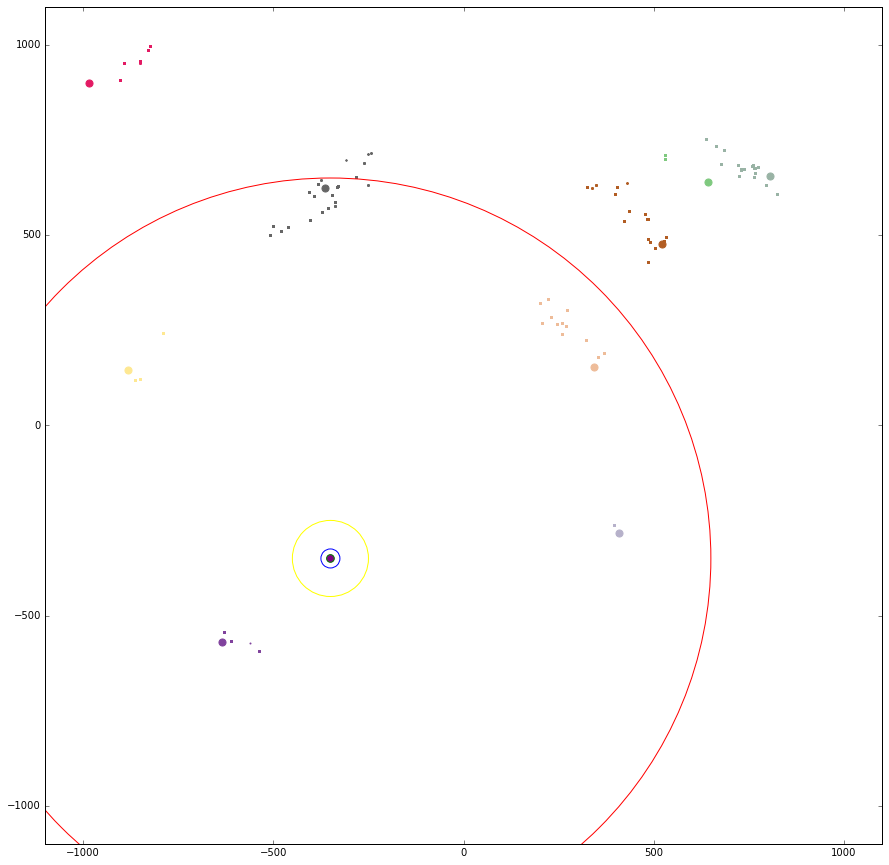

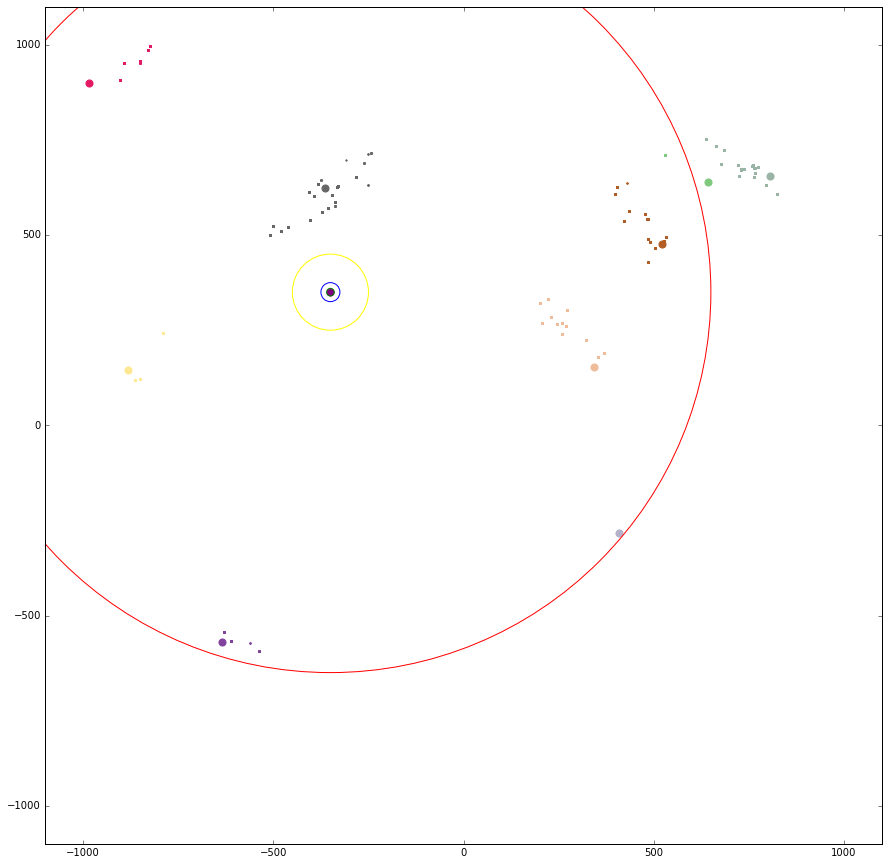

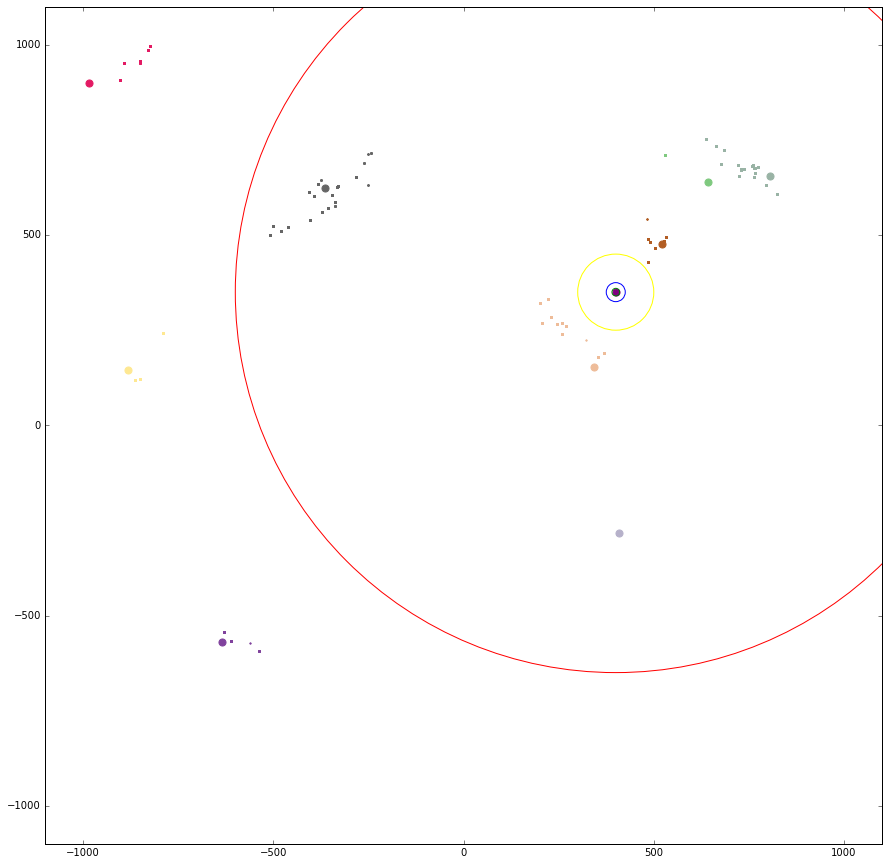

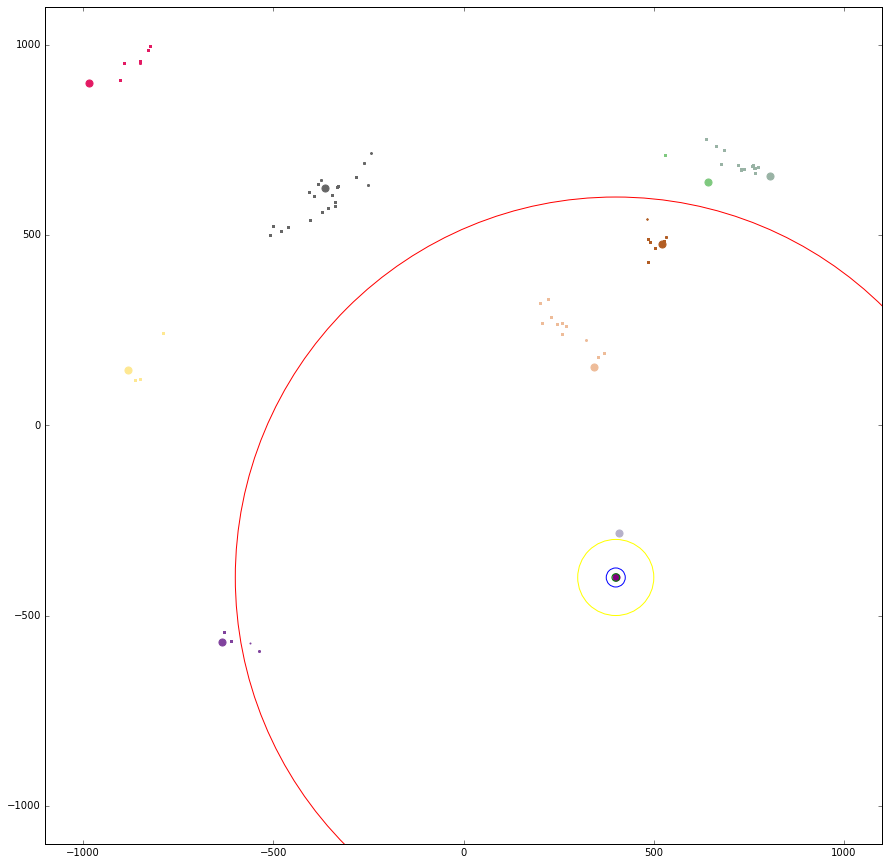

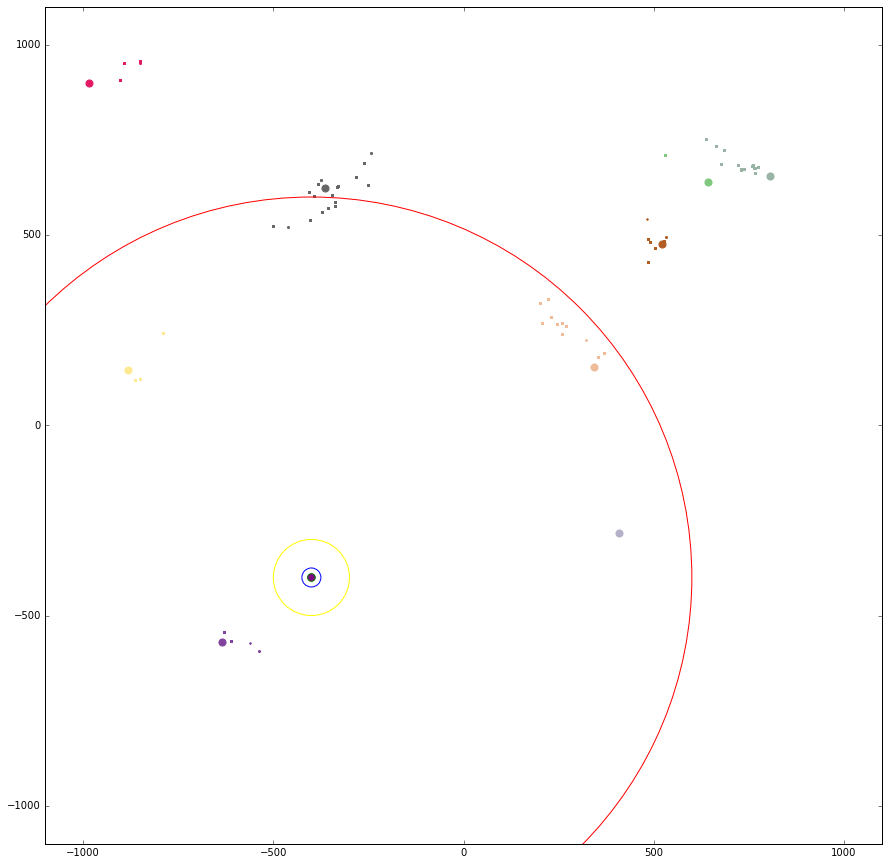

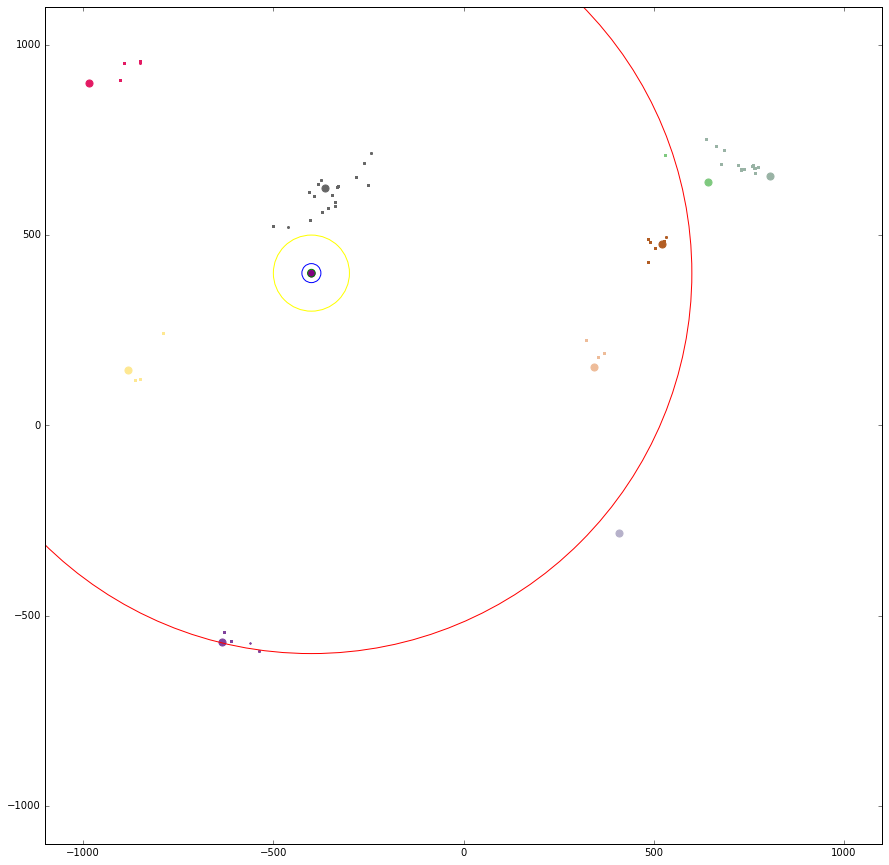

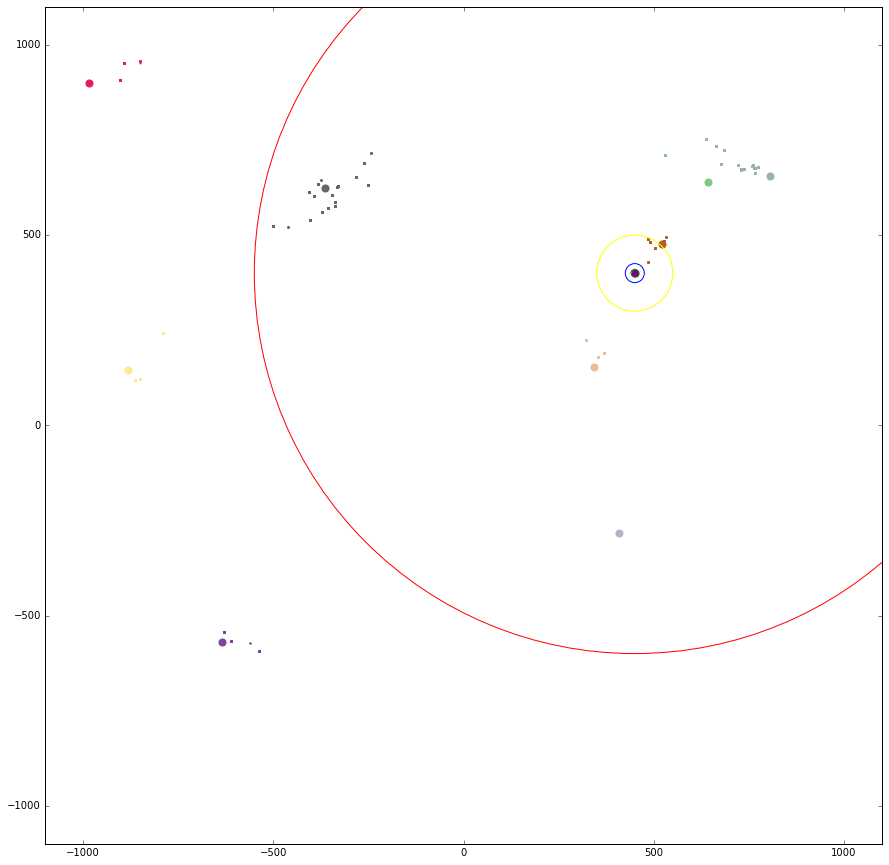

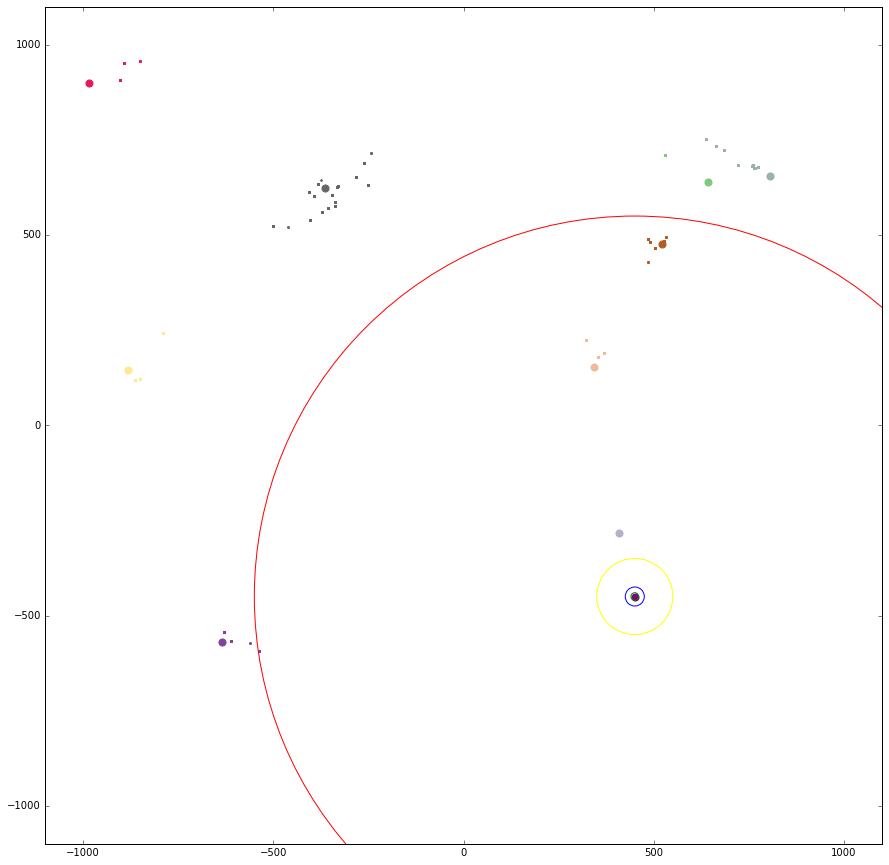

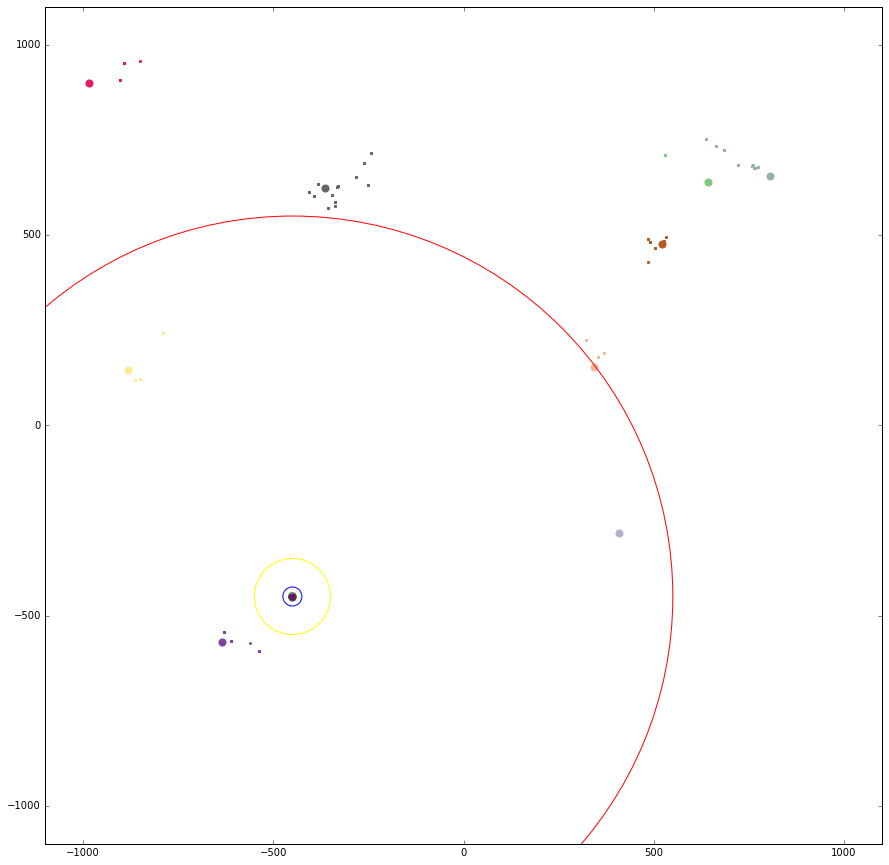

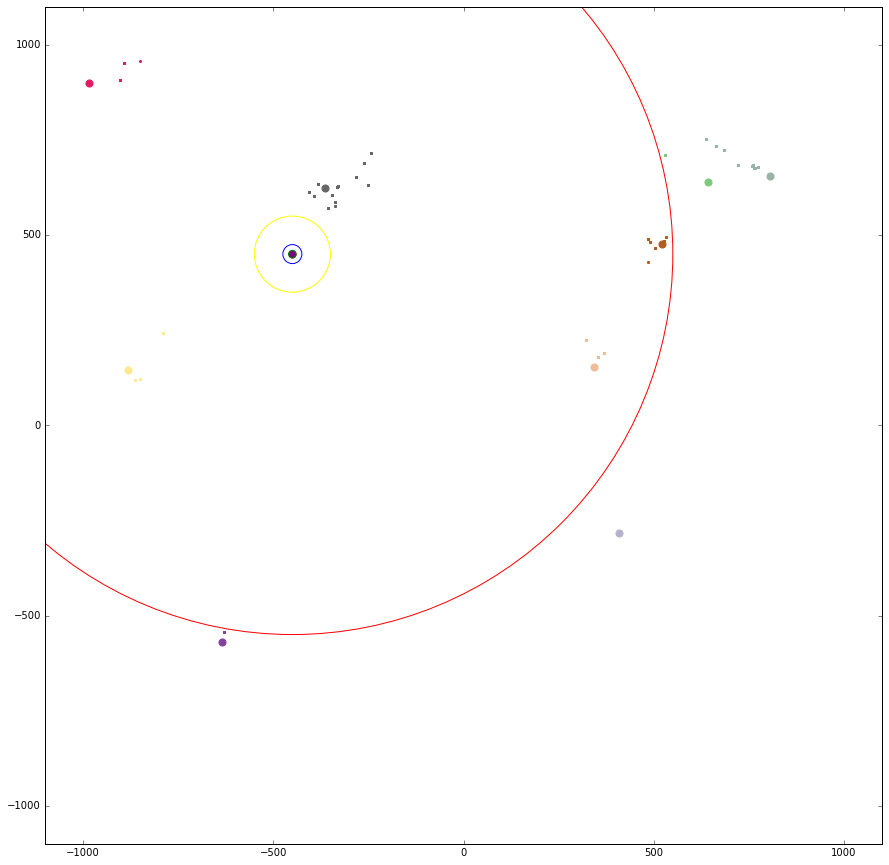

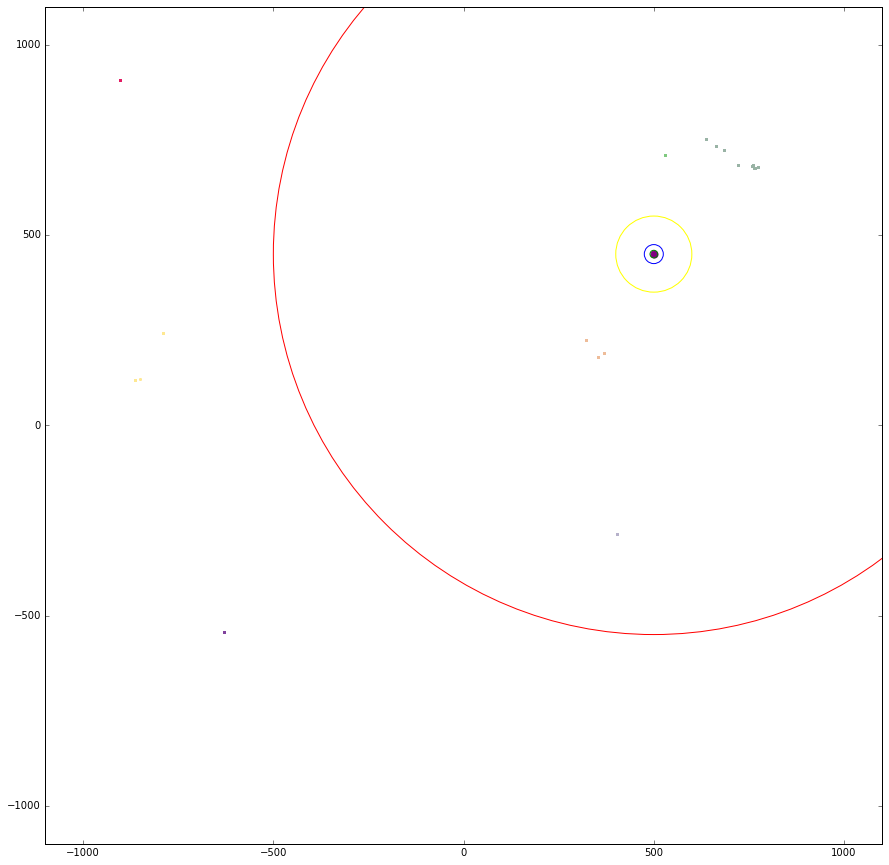

In [183]:
pokemon_simulation(log_frequency=1, no_change_update_steps=5)